# Proyecto 2 MDD
Por Sebastián Bustamante.

Esta primera parte del proyecto se centra en limpiar el dataset

dataset en kaggle: https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [1]:
# Importando los modulos a usar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from yellowbrick.classifier import ConfusionMatrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("set_Sebastian_Bustamante.csv")
df.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   
3        Room_Type 1        211          2018              5            20   
4        Room_Type 1         48          2018              4            11   

  market_segment_type  repeated_guest  no_of_previous_cancellations  \
0             Offline               0                             0   
1              Online               0                             0   
2              Online               0                             0   
3              Online               0                             0   
4              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

## Empezar con la limpieza del dataset

Eliminar la columna del ID

In [3]:
df = df.drop('Booking_ID', axis = 1)

Pasar las variables categóricas a numéricas

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder_type_of_meal_plan = LabelEncoder()
label_encoder_room_type_reserved = LabelEncoder()
label_encoder_market_segment_type = LabelEncoder()
label_encoder_booking_status = LabelEncoder()

df['type_of_meal_plan'] = label_encoder_type_of_meal_plan.fit_transform(df['type_of_meal_plan'])
df['room_type_reserved'] = label_encoder_room_type_reserved.fit_transform(df['room_type_reserved'])
df['market_segment_type'] = label_encoder_market_segment_type.fit_transform(df['market_segment_type'])
df['booking_status'] = label_encoder_booking_status.fit_transform(df['booking_status'])

In [5]:
le_name_mapping = dict(zip(label_encoder_booking_status.classes_, label_encoder_booking_status.transform(label_encoder_booking_status.classes_)))
print(le_name_mapping)

{'Canceled': 0, 'Not_Canceled': 1}


Separar la variable objetivo de las demás

In [6]:
X = df.drop('booking_status', axis = 1)
X = X.values
y = df['booking_status']

Naive Bayes sin balancear las clases, para comparar el desempeño balanceado del no balanceado y ver si existe el problema.

De todas formas se escala toda la data:

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

Luego generar los conjuntos de entrenamiento y prueba:

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Ahora probar Naive Bayes, sin balancear

In [9]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
previsoes = naive_bayes.predict(X_test)

In [10]:
cm = ConfusionMatrix(naive_bayes, classes=["Not Canceled", "Canceled"])
cm.fit(X_train, y_train)
score_naive_gaussian = cm.score(X_test, y_test)
score_naive_gaussian
cm.show()

<Axes: title={'center': 'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [11]:
classification_naive_gaussian = (classification_report(y_test, previsoes))
print(classification_naive_gaussian)

              precision    recall  f1-score   support

           0       0.37      0.97      0.54      2401
           1       0.94      0.20      0.32      4854

    accuracy                           0.45      7255
   macro avg       0.65      0.58      0.43      7255
weighted avg       0.75      0.45      0.40      7255



In [12]:
# Curva ROC
y_prob = naive_bayes.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = auc(fpr, tpr)

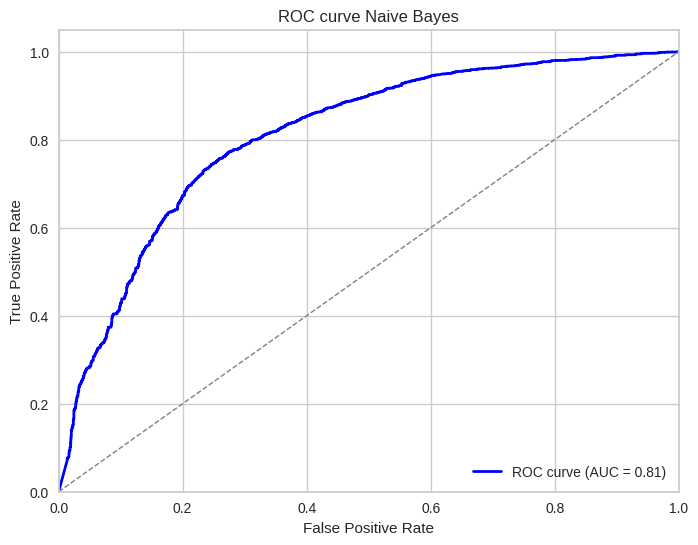

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Naive Bayes')
plt.legend(loc='lower right')
plt.show()

Ahora que se han hecho los calculos sin balancear, se balancean las clases.

Balancear las clases

En el EDA vimos que el dataset está desbalanceado. Hay una relación 2:1 entre las reservas no canceladas y las canceladas

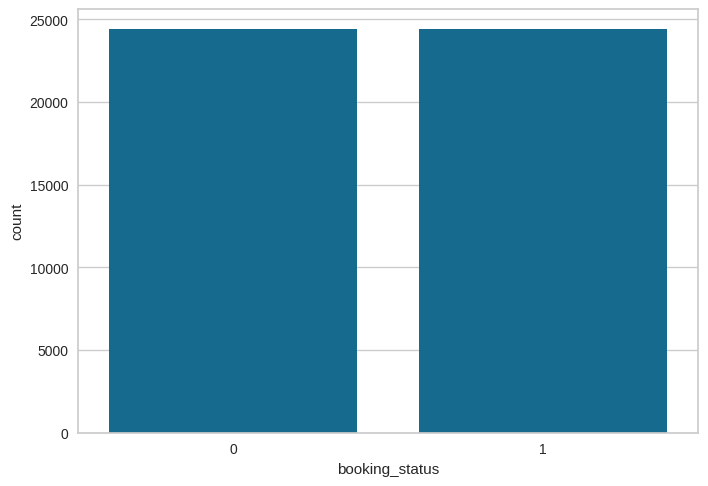

In [14]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X, y)
ax = sns.countplot(x=y)

Cambiar las escalas

Se usa StandardScaler para poner toda la data en la misma escala

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

Transformar la data en entrenamiento y testeo, se va a usar el 20% de los datos para los testeos.

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Modelos a usar
Con el dataset ya limpio se pueden usar diferentes modelos

### Naive Bayes
Se usa el modelo de Naive Bayes, testeando el modelo Gaussiano con la data Normal

In [17]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
previsoes = naive_bayes.predict(X_test)

Resultados

In [18]:
cm = ConfusionMatrix(naive_bayes, classes=["Not Canceled", "Canceled"])
cm.fit(X_train, y_train)
score_naive_gaussian = cm.score(X_test, y_test)
score_naive_gaussian
cm.show()


<Axes: title={'center': 'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [19]:
classification_naive_gaussian = (classification_report(y_test, previsoes))
print(classification_naive_gaussian)

              precision    recall  f1-score   support

           0       0.54      0.98      0.70      4895
           1       0.89      0.16      0.27      4861

    accuracy                           0.57      9756
   macro avg       0.72      0.57      0.48      9756
weighted avg       0.71      0.57      0.48      9756



In [20]:
# Curva ROC
y_prob = naive_bayes.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = auc(fpr, tpr)

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Naive Bayes')
plt.legend(loc='lower right')
plt.show()

### Árboles de decisiones
Árbol de decisión, testea Entropía y cálculos de Gini.
Usar GridSearch para revisar cuales son las mejores métricas para usar.


In [22]:
min_split = np.array([2, 3, 4, 5, 6, 7])
max_nvl = np.array([3, 4, 5, 6, 7, 9, 11])
alg = ['entropy', 'gini']
values_grid = {'min_samples_split': min_split, 'max_depth': max_nvl, 'criterion': alg}

model = DecisionTreeClassifier()
gridDecisionTree = GridSearchCV(estimator = model, param_grid = values_grid, cv = 5)
gridDecisionTree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  9, 11]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7])})

DecisionTree con GridSearch

In [23]:
print('Mín Split: ', gridDecisionTree.best_estimator_.min_samples_split)
print('Max Nvl: ', gridDecisionTree.best_estimator_.max_depth)
print('Algorithm: ', gridDecisionTree.best_estimator_.criterion)
print('Score: ', gridDecisionTree.best_score_)

Mín Split:  2
Max Nvl:  11
Algorithm:  gini
Score:  0.8648524631826973


Resultados de DecisionTree

In [24]:
decision_tree = DecisionTreeClassifier(criterion = 'gini', min_samples_split = 2, max_depth= 11, random_state=0)
decision_tree.fit(X_train, y_train)
previsoes = decision_tree.predict(X_test)

In [25]:
cm = ConfusionMatrix(decision_tree, classes=["Canceled", "Not canceled"])
cm.fit(X_train, y_train)
print(cm.score(X_test, y_test))
cm.show()

0.8682861828618286


<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [26]:
classification_decision = (classification_report(y_test, previsoes))
print(classification_decision)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4895
           1       0.88      0.85      0.87      4861

    accuracy                           0.87      9756
   macro avg       0.87      0.87      0.87      9756
weighted avg       0.87      0.87      0.87      9756



In [27]:
score_tree = 0.8682861828618286

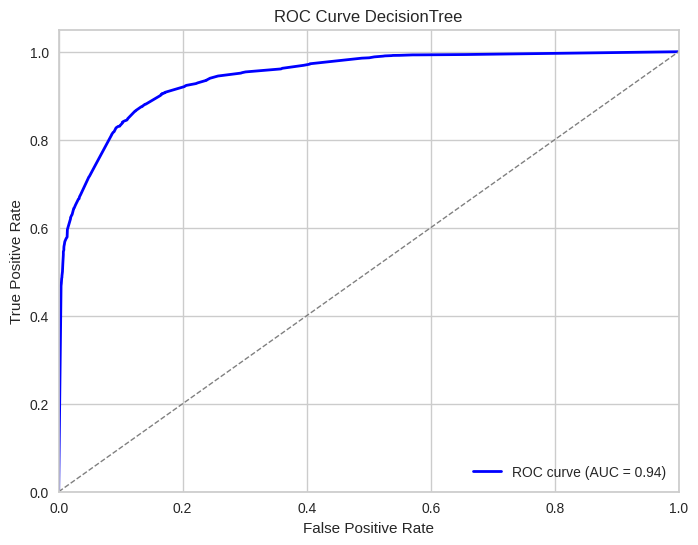

In [28]:
# Curva ROC
y_score = decision_tree.predict_proba(X_test)[:, 1]  # Use decision scores as probabilities

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute AUC score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve DecisionTree')
plt.legend(loc='lower right')
plt.show()

Ver las variables mas importantes del modelo

In [29]:
columns = df.drop('booking_status', axis = 1).columns
feature_imp = pd.Series(decision_tree.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp

lead_time                               0.403553
market_segment_type                     0.151399
no_of_special_requests                  0.129278
avg_price_per_room                      0.102189
arrival_month                           0.066720
no_of_adults                            0.028981
arrival_date                            0.027739
no_of_weekend_nights                    0.027449
arrival_year                            0.018099
no_of_week_nights                       0.017676
required_car_parking_space              0.011400
type_of_meal_plan                       0.007449
room_type_reserved                      0.004703
repeated_guest                          0.002290
no_of_children                          0.000951
no_of_previous_bookings_not_canceled    0.000123
no_of_previous_cancellations            0.000000
dtype: float64

El árbol en sí

In [30]:
plot_tree(decision_tree, filled=True)
plt.show()

### RandomForest
Se usa el modelo de RandomForest con cálculos de Entropía y Gini

Aplicar GridSearch

In [31]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = np.array([100])
alg = ['entropy', 'gini']
min_split = np.array([2, 3, 4, 5, 6, 7])
max_nvl = np.array([3, 4, 5, 6, 7, 9, 11])
values_grid = {'n_estimators': n_estimators, 'min_samples_split': min_split, 'max_depth': max_nvl, 'criterion': alg}

model = RandomForestClassifier()
gridRandomForest = GridSearchCV(estimator = model, param_grid = values_grid, cv = 5)
gridRandomForest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  9, 11]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7]),
                         'n_estimators': array([100])})

RandomForest con GridSearch

In [32]:
print('Algorithm: ', gridRandomForest.best_estimator_.criterion)
print('Score: ', gridRandomForest.best_score_)
print('Mín Split: ', gridRandomForest.best_estimator_.min_samples_split)
print('Max Nvl: ', gridRandomForest.best_estimator_.max_depth)

Algorithm:  gini
Score:  0.8715917788509054
Mín Split:  3
Max Nvl:  11


Ejecutar RandomForest

In [33]:
random_forest = RandomForestClassifier(n_estimators = 100, min_samples_split = 2, max_depth= 11,  criterion = 'gini', random_state = 0)
random_forest.fit(X_train, y_train)
previsoes = random_forest.predict(X_test)

Resultados

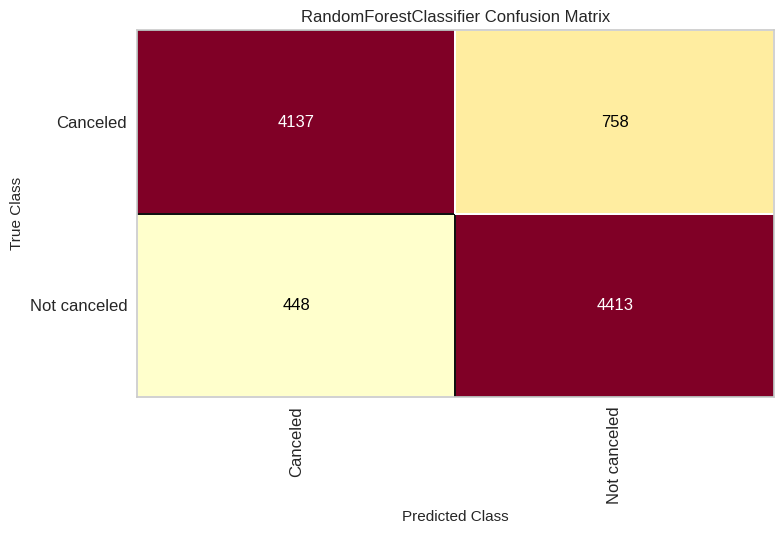

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [34]:
cm = ConfusionMatrix(random_forest, classes=["Canceled", "Not canceled"])
cm.fit(X_train, y_train)
score_random = cm.score(X_test, y_test)
score_random
cm.show()

In [35]:
classification_random = (classification_report(y_test, previsoes))
print(classification_random)

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      4895
           1       0.85      0.91      0.88      4861

    accuracy                           0.88      9756
   macro avg       0.88      0.88      0.88      9756
weighted avg       0.88      0.88      0.88      9756



Revisar las variables más importantes del modelo

In [36]:
feature_imp_random = pd.Series(random_forest.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp_random

lead_time                               0.378389
no_of_special_requests                  0.164496
avg_price_per_room                      0.110315
market_segment_type                     0.089448
arrival_month                           0.069614
arrival_year                            0.045713
arrival_date                            0.031219
no_of_week_nights                       0.025339
no_of_weekend_nights                    0.023737
no_of_adults                            0.017487
type_of_meal_plan                       0.013504
required_car_parking_space              0.009921
room_type_reserved                      0.008047
repeated_guest                          0.004593
no_of_previous_bookings_not_canceled    0.004301
no_of_children                          0.003203
no_of_previous_cancellations            0.000675
dtype: float64

### ExtraTrees
Modelo de ExtraTrees con calculos de Entropía y Gini

Aplicar GridSearch

In [37]:
from sklearn.ensemble import ExtraTreesClassifier

n_estimators = np.array([100])
alg = ['entropy', 'gini']
values_grid = {'n_estimators': n_estimators, 'criterion': alg}

model = ExtraTreesClassifier()
gridExtraTrees = GridSearchCV(estimator = model, param_grid = values_grid, cv = 5)
gridExtraTrees.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'n_estimators': array([100])})

ExtraTrees con GridSearch

In [38]:
print('Algorithm: ', gridExtraTrees.best_estimator_.criterion)
print('Score: ', gridExtraTrees.best_score_)

Algorithm:  gini
Score:  0.927967323053504


Ejecutando ExtraTrees

In [39]:
extra_trees = ExtraTreesClassifier(n_estimators = 100, criterion = 'gini', random_state = 0)
extra_trees.fit(X_train, y_train)
previsoes = extra_trees.predict(X_test)

Resultados

0.9440344403444034

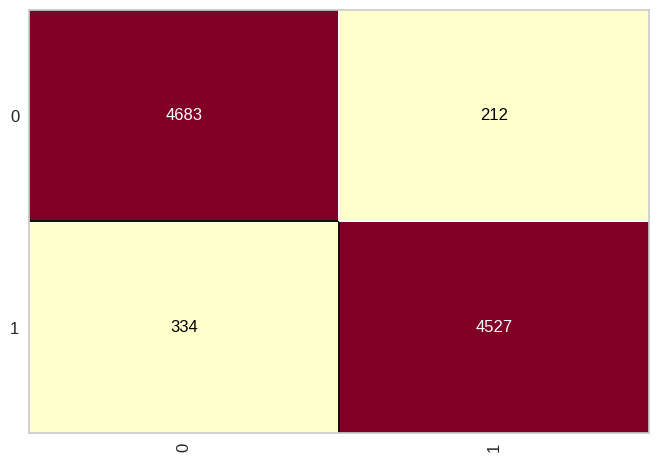

In [40]:
cm = ConfusionMatrix(extra_trees)
cm.fit(X_train, y_train)
score_extra = cm.score(X_test, y_test)
score_extra

In [41]:
classification_extra = (classification_report(y_test, previsoes))
print(classification_extra)

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      4895
           1       0.96      0.93      0.94      4861

    accuracy                           0.94      9756
   macro avg       0.94      0.94      0.94      9756
weighted avg       0.94      0.94      0.94      9756



Revisando las variables mas importantes del modelo

In [42]:
feature_extra = pd.Series(extra_trees.feature_importances_, index = columns).sort_values(ascending = False)
feature_extra

lead_time                               0.281013
avg_price_per_room                      0.117923
no_of_special_requests                  0.113423
arrival_month                           0.093171
arrival_date                            0.092086
no_of_week_nights                       0.063817
market_segment_type                     0.053671
no_of_weekend_nights                    0.045029
arrival_year                            0.036646
no_of_adults                            0.030584
type_of_meal_plan                       0.022695
room_type_reserved                      0.020403
no_of_children                          0.009916
repeated_guest                          0.009756
required_car_parking_space              0.008675
no_of_previous_cancellations            0.000616
no_of_previous_bookings_not_canceled    0.000575
dtype: float64

### KMeans

In [43]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 2, random_state= 0)
model.fit(X_train)
previsoes = model.predict(X_test)

Resultados

In [44]:
classification_kmeans_standard = (accuracy_score(y_test, previsoes))
classification_kmeans_standard
score_kmeans = classification_kmeans_standard

### K Neighbors
KNN con GridSearch para buscar las mejores metricas para el modelo

Usar GridSearch

In [45]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

k_list = list(range(1,10))
k_values = dict(n_neighbors = k_list)
grid = GridSearchCV(knn, k_values, cv = 2, scoring = 'accuracy', n_jobs = -1)
grid.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy')

KNN con GridSearch

In [46]:
grid.best_params_, grid.best_score_

({'n_neighbors': 1}, 0.865749282492825)

Ejecutar KNN

In [47]:
# Ojo que se tiene n=1! Estos parametros fueron determinados con la gridsearch
knn = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)
previsoes = knn.predict(X_test)

Resultados

0.9074415744157441

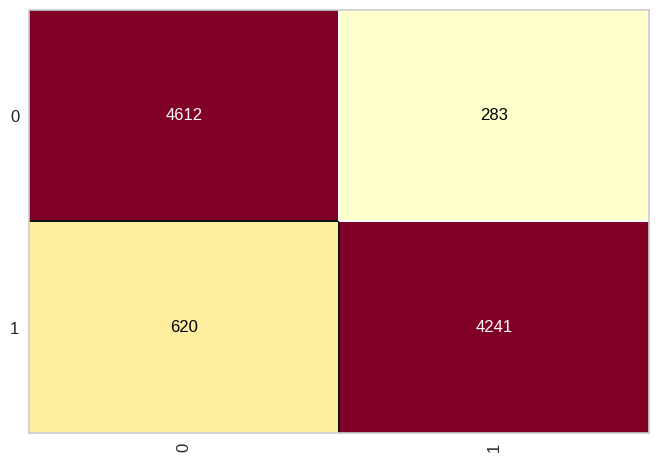

In [48]:
cm = ConfusionMatrix(knn)
cm.fit(X_train, y_train)
score_knn = cm.score(X_test, y_test)
score_knn

In [49]:
classification_knn = (classification_report(y_test, previsoes))
print(classification_knn)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4895
           1       0.94      0.87      0.90      4861

    accuracy                           0.91      9756
   macro avg       0.91      0.91      0.91      9756
weighted avg       0.91      0.91      0.91      9756



### Regresion Logistica

In [50]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(random_state = 1, max_iter=1000)
logistic.fit(X_train, y_train)
previsoes = logistic.predict(X_test)

Resultados

0.7764452644526445

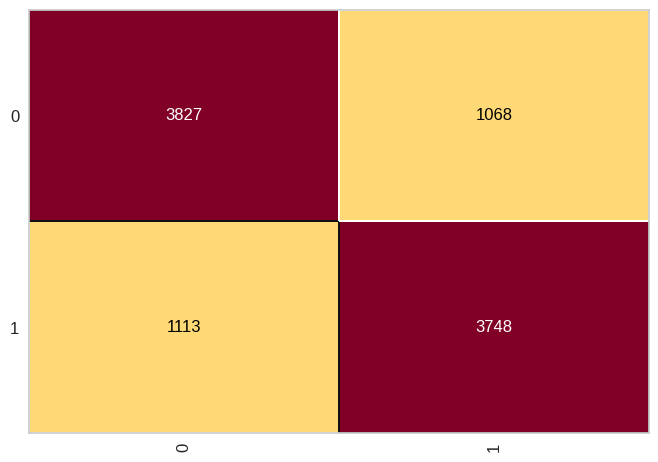

In [51]:
cm = ConfusionMatrix(logistic)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

In [52]:
logistic_normal = (classification_report(y_test, previsoes))
print(logistic_normal)

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      4895
           1       0.78      0.77      0.77      4861

    accuracy                           0.78      9756
   macro avg       0.78      0.78      0.78      9756
weighted avg       0.78      0.78      0.78      9756



In [53]:
logistic_normal = 0.7807161404947383

Neural Network

In [54]:
from keras import utils
y_convert = utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X_standard, y_convert, test_size = 0.3, random_state = 0)

2024-05-24 12:53:19.699253: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 12:53:19.768450: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 12:53:20.065696: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 12:53:21.760337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


NameError: name 'X_standard' is not defined

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import regularizers

model = Sequential()
model.add(Dense(200, input_dim = 17, kernel_initializer = 'normal', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer = 'normal', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, kernel_initializer = 'normal', activation = 'softmax'))

from tensorflow.keras.optimizers import Adam
optimitzer = Adam(amsgrad=True)

model.compile(loss='categorical_crossentropy', optimizer = optimitzer, metrics=['acc'])

model.fit(X_train, y_train, epochs = 100, batch_size = 400, validation_data = (X_test, y_test), verbose = 1)

Epoch 1/100


/home/sebastian122342/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.7264 - loss: 0.5777 - val_acc: 0.7944 - val_loss: 0.4456
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7937 - loss: 0.4393 - val_acc: 0.8003 - val_loss: 0.4276
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8054 - loss: 0.4235 - val_acc: 0.8070 - val_loss: 0.4204
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8080 - loss: 0.4156 - val_acc: 0.8124 - val_loss: 0.4098
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8164 - loss: 0.4035 - val_acc: 0.8169 - val_loss: 0.4005
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8246 - loss: 0.3891 - val_acc: 0.8226 - val_loss: 0.3929
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8251 - loss: 0.3900 - val_acc: 0.8253 - val_loss: 0.3870
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8262 - loss: 0.3822 - val_acc: 0.8268 - val_loss: 0.3836
Epoch 9/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8298 - loss: 0.3

In [ ]:
score_neural_network = 0.8737

Cambiando las variables clabes para predecir la salida

CHI-2

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

features = X
target = y

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(columns),columns = ['Chi Squared Score']) 

In [ ]:
featureScores.sort_values(by = 'Chi Squared Score', ascending = False).round(2)

Chi Squared Score
lead_time                                     797722.63
avg_price_per_room                             12869.91
no_of_previous_bookings_not_canceled            5390.79
no_of_special_requests                          4088.34
repeated_guest                                   819.60
required_car_parking_space                       485.70
no_of_week_nights                                441.53
no_of_previous_cancellations                     418.67
no_of_weekend_nights                             183.33
market_segment_type                              132.63
no_of_children                                    97.71
room_type_reserved                                97.07
no_of_adults                                      62.61
type_of_meal_plan                                 58.37
arrival_date                                      22.78
arrival_month                                     14.25
arrival_year                                       0.13

In [ ]:
feature_imp

lead_time                               0.407987
market_segment_type                     0.151215
no_of_special_requests                  0.132067
avg_price_per_room                      0.102131
arrival_month                           0.061918
arrival_date                            0.030956
no_of_week_nights                       0.026384
no_of_weekend_nights                    0.025761
no_of_adults                            0.022820
arrival_year                            0.015264
required_car_parking_space              0.009477
type_of_meal_plan                       0.009072
room_type_reserved                      0.003504
no_of_children                          0.001242
repeated_guest                          0.000203
no_of_previous_cancellations            0.000000
no_of_previous_bookings_not_canceled    0.000000
dtype: float64

In [ ]:
feature_imp_random

lead_time                               0.375165
no_of_special_requests                  0.163952
avg_price_per_room                      0.106350
market_segment_type                     0.095152
arrival_month                           0.067997
arrival_year                            0.047530
arrival_date                            0.030981
no_of_weekend_nights                    0.026034
no_of_week_nights                       0.024160
no_of_adults                            0.018491
type_of_meal_plan                       0.013311
required_car_parking_space              0.010086
room_type_reserved                      0.008493
repeated_guest                          0.004720
no_of_children                          0.003514
no_of_previous_bookings_not_canceled    0.003388
no_of_previous_cancellations            0.000675
dtype: float64

In [ ]:
feature_extra

lead_time                               0.276327
avg_price_per_room                      0.117736
no_of_special_requests                  0.112428
arrival_month                           0.093471
arrival_date                            0.091680
no_of_week_nights                       0.062540
market_segment_type                     0.055625
no_of_weekend_nights                    0.046157
arrival_year                            0.038622
no_of_adults                            0.032076
type_of_meal_plan                       0.023076
room_type_reserved                      0.020770
no_of_children                          0.009966
repeated_guest                          0.009486
required_car_parking_space              0.008694
no_of_previous_bookings_not_canceled    0.000745
no_of_previous_cancellations            0.000600
dtype: float64

In [ ]:
Naive_dict_v1 = {'Model':'Naive Bayes',
               'Scaling':'Normal Data',
               'Type':'Gaussian',
               'Precision':score_naive_gaussian}

Decision_dict = {'Model':'Decision Tree',
               'Scaling':'Normal Data',
               'Type': 'Gini',
               'Precision':score_tree}

Random_dict = {'Model':'Random Forest',
               'Scaling':'Normal Data',
               'Type': 'Gini',
               'Precision':score_random}

Extra_dict = {'Model':'Extra Trees',
               'Scaling':'Normal Data',
               'Type': 'Gini',
               'Precision':score_extra}

K_Means_dict_v2 = {'Model':'Means',
               'Scaling':'Normal',
               'Type':'-',
               'Precision':score_kmeans}

KNN_dict_v2 = {'Model':'KNN',
               'Scaling':'Normal',
               'Type':'-',
               'Precision':score_knn}

Logistic_dict_v1 = {'Model':'Logistic Regression',
               'Scaling':'Normal Data',
               'Type':'-',
               'Precision':logistic_normal}
neural_dict_v1 = {'Model':'Neural Network',
               'Scaling':'StandardScaler',
               'Type':'-',
               'Precision':score_neural_network}

In [ ]:
resume = pd.DataFrame({'Naive Bayes':pd.Series(Naive_dict_v1),
                       'Decision Tree':pd.Series(Decision_dict),
                       'Random Forest':pd.Series(Random_dict),
                       'Extra Trees':pd.Series(Extra_dict),
                       'K-Means':pd.Series(K_Means_dict_v2),
                       'KNN':pd.Series(KNN_dict_v2),
                       'Logistic Regression':pd.Series(Logistic_dict_v1),
                       'Neural Network':pd.Series(neural_dict_v1)
                      })

In [ ]:
resume

Naive Bayes  Decision Tree  Random Forest  Extra Trees   K-Means  \
Model      Naive Bayes  Decision Tree  Random Forest  Extra Trees     Means   
Scaling    Normal Data    Normal Data    Normal Data  Normal Data    Normal   
Type          Gaussian           Gini           Gini         Gini         -   
Precision     0.566284       0.800703       0.871395     0.934126  0.324382   

                KNN  Logistic Regression  Neural Network  
Model           KNN  Logistic Regression  Neural Network  
Scaling      Normal          Normal Data  StandardScaler  
Type              -                    -               -  
Precision  0.873377             0.780716          0.8737